# Using the Scatterer module

In this notebook, we will be describing how to use the `Free_Space_Scatterer` class provided in the Scatterer module. This class provides access to the functions provided by the `Free_Space_Scatterer` class of SCATMECH. These include the models
* RayleighScatterer
* RayleighGansSphereScatterer
* MieScatterer
* CoatedMieScatterer
* MultilayerCoatedMieScatterer
* Optically_Active_Sphere_Scatterer
* TMatrix_Axisymmetric_Scatterer

First, import the libraries we will need. We will be graphing some data, and using the NumPy package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pySCATMECH.scatterer import *    

## Mie scattering

Let's start by looking at scattering by homogeneous spheres (Mie scatering).  We start by creating a model and setting its parameters:

In [2]:
parameters = {
            'lambda' : 0.532,
            'medium' : 1,
            'radius' : 0.1,
            'sphere' : 1.59}

model = Free_Space_Scatterer("MieScatterer",parameters)

print(model)

{None : 'MieScatterer',
'lambda' : '0.532',
'medium' : '(1,0)',
'radius' : '0.1',
'sphere' : '(1.59,0)'}


We can evaluate the Mueller matrix differential scattering cross section in any pair of directions, defined by two directional vectors. The basis set for the Mueller matrix is perpendicular and parallel to the plane of scattering, defined by the incident and scattering directions.

In [3]:
theta = 45*deg

vin = [0,0,1] 
vout = [np.sin(theta),0,np.cos(theta)]

m = model.DifferentialScatteringCrossSection(vin,vout)
print(m)

[[ 2.30829762e-03 -6.16046580e-04  0.00000000e+00  0.00000000e+00]
 [-6.16046580e-04  2.30829762e-03  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.22445889e-03 -2.25210041e-05]
 [ 0.00000000e+00  0.00000000e+00  2.25210041e-05  2.22445889e-03]]


Let's plot the scattering function:

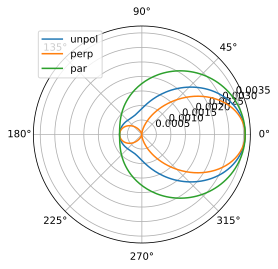

In [4]:
def dsc(theta):
    vin = [0,0,1]
    vout = [np.sin(theta),0,np.cos(theta)]
    return model.DifferentialScatteringCrossSection(vin,vout)
    
angles = np.linspace(0,2*pi,180)
results = [dsc(angle) for angle in angles]

spol = Polarization('S') # perpendicular to the scattering plane
ppol = Polarization('P') # parallel to the scattering plane
upol = Polarization('U') # unpolarized 
usens = Sensitivity('U') # unpolarized sensitivity

plt.figure()
plt.polar(angles, [usens @ r @ upol for r in results], label = "unpol")
plt.polar(angles, [usens @ r @ spol for r in results], label = "perp")
plt.polar(angles, [usens @ r @ ppol for r in results], label = "par")
plt.legend()
plt.show()

In this next step, we look at a 0.04 µm diameter gold sphere as a function of wavelength. Here, we integrate the scatter and show the total scattering cross section as a function of wavelength. Notice the surface plasmon resonance at around 0.52 µm.

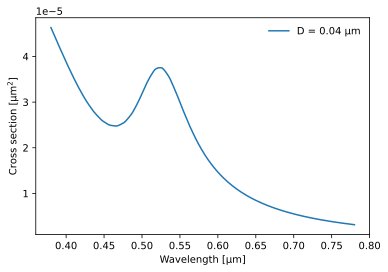

In [5]:
parameters = {
            'lambda' : 0.532,
            'medium' : 1,
            'radius' : 0.03,
            'sphere' : 'gold'}

model = Free_Space_Scatterer("MieScatterer", parameters)

def integrate_scatter(model, wavelength, steps):
    "Integrate `model` at `wavelength`, performing the integral in `steps` steps."
    integ = 0
    dtheta = pi / (steps - 1)
    parameters['lambda'] = wavelength
    model.setParameters(parameters)
    vin = [0, 0, 1]
    angles = np.arange(0, pi, dtheta)
    # Integrate angles from 0 to pi...
    for theta in angles:
        vout = [np.sin(theta), 0, np.cos(theta)]
        m = model.DifferentialScatteringCrossSection(vin, vout)
        integ += m[0][0] * np.abs(np.sin(theta))
    integ *= 2 * pi * dtheta
    return integ

wavelengths = np.linspace(0.380,0.780,200)

plt.figure()

# Diameter 0.04 µm...
D = 0.04
parameters['radius'] = D/2
model.setParameters(parameters)

crosssection = [integrate_scatter(model,L,50) for L in wavelengths]

plt.plot(wavelengths, crosssection, label = "D = %g µm"%D)

plt.legend(frameon=False)
plt.xlabel("Wavelength [µm]")
plt.ylabel("Cross section [µm$^2$]")
plt.show()

## Mie scattering with a coating

The `CoatedMieScatterer` model implements Mie theory extended to coated spheres.  Let's see what the absorption, scattering, and extinction cross sections look like for different thicknesses of gold on glass spheres in water.

In [6]:
parameters = {
            'lambda' : 0.532,
            'medium' : 'water', 
            'radius' : 0.03,
            'sphere' : 'glass',
            'coating' : 'gold',
            'thickness' : 0.005}

model = Free_Space_Scatterer("CoatedMieScatterer", parameters)

def extinction(model, wavelength):
    "Calculate the extinction coefficient at a given `wavelength` for a given `model`."
    parameters['lambda'] = wavelength
    model.setParameters(parameters)
    vin = [0, 0, 1]
    return model.Extinction(vin)[0][0]

def integrated_scatter(model,wavelength,steps):
    "Integrate the scatter over polar angle"
    integ = 0
    dtheta = pi/(steps - 1)
    parameters['lambda'] = wavelength
    model.setParameters(parameters)
    vin = [0, 0, 1]
    for theta in np.linspace(0, pi, steps):
        vout = [np.sin(theta), 0, np.cos(theta)]
        m = model.DifferentialScatteringCrossSection(vin, vout)
        integ += m[0][0]*np.abs(np.sin(theta))
    integ *= 2*pi*dtheta
    return integ

wavelengths = np.linspace(0.500, 1.300, 200)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for t in [0.002,0.003,0.004,0.005,0.006,0.007,0.008]:
    parameters['thickness'] = t
    sca = np.array([integrated_scatter(model,L,50) for L in wavelengths])
    ext = np.array([extinction(model,L) for L in wavelengths])
    abs = ext-sca
    ax1.plot(wavelengths, sca*1000, label = "t = %g"%t)
    ax2.plot(wavelengths, ext*1000, label = "t = %g"%t)
    ax3.plot(wavelengths, abs*1000, label = "t = %g"%t)
    
ax1.legend()
ax1.set_title("Scattering")
ax2.set_title("Extinction")
ax3.set_title("Absorption")
ax1.set_ylabel("Cross Section [µm$^2$/1000]")
ax1.set_xlabel("Wavelength [µm]")
ax2.set_xlabel("Wavelength [µm]")
ax3.set_xlabel("Wavelength [µm]")
plt.show()

## Optically active sphere

In the following, we look at the extinction matrix for a 2 µm diameter sphere that has a small index difference for right-hand-circular polarization (typical numbers for sucrose).  The resulting matrix shows some optical rotation and some circular diattenuation.

In [7]:
parameters = {
            'lambda' : 0.589,
            'medium' : 1,
            'radius' : 1,
            'materialright' : 1.56+ 6.9E-7,
            'materialleft' : 1.56}

model = Free_Space_Scatterer("Optically_Active_Sphere_Scatterer",parameters)

def extinction(model,wavelength):
    model.setParameters(wavelength=wavelength)
    vin = [0,0,1]
    return model.Extinction(vin)

extmatrix = model.Extinction([0,0,1])

print(extmatrix)

[[ 8.32522992e+00  0.00000000e+00  0.00000000e+00  7.94028248e-06]
 [ 0.00000000e+00  8.32522992e+00  3.05860149e-06 -0.00000000e+00]
 [ 0.00000000e+00 -3.05860149e-06  8.32522992e+00  0.00000000e+00]
 [ 7.94028248e-06  0.00000000e+00 -0.00000000e+00  8.32522992e+00]]


## Ellipsoids

In the following, we calculate the extinction coefficient for ellipsoidal gold particles, where the major axis is 20 µm and the minor axis is 6 µm. We then calculate the Mueller matrix transmittance assuming a concentration-thickness product of 10<sup>5</sup> µm<sup>-2</sup>.  When the radiation is incident perpendicular to the axis of the ellipsoids, the resulting Mueller matrix behaves very much like a polarizer.  When the radiation is incident along the axis of the ellipsoids, the resulting Mueller matrix is just absorbing.

In [8]:
shape = {None : 'Ellipsoid_Axisymmetric_Shape',
        'npoints' : '100',
        'vertical' : '0.010',
        'horizontal' : '0.003'
        }

tmatrix = {'lambda' : 0.8,
        'medium' : 1.4,
        'Shape' : shape,
        'particle' : 'gold',
        'lmax' : '30',
        'mmax' : '0'}

model = Free_Space_Scatterer("TMatrix_Axisymmetric_Scatterer",tmatrix)

extCoeff100 = model.Extinction([1,0,0])
extCoeff001 = model.Extinction([0,0,1])

print("Mueller matrix transmittance perpendicular to ellipsoid axis:")
print(MuellerExp(-extCoeff100 * 10**5),'\n')
print("Mueller matrix transmittance parallel to ellipsoid axis:")
print(MuellerExp(-extCoeff001 * 10**5),'\n')


Mueller matrix transmittance perpendicular to ellipsoid axis:
[[ 4.90951752e-01  4.90951752e-01  8.56709626e-24  6.07946914e-24]
 [ 4.90951752e-01  4.90951752e-01  8.55781735e-24  6.05189921e-24]
 [-1.63365318e-22 -1.63342992e-22 -3.18191980e-06  7.75832676e-06]
 [-1.47979786e-21 -1.47981003e-21 -7.75832676e-06 -3.18191980e-06]] 

Mueller matrix transmittance parallel to ellipsoid axis:
[[ 1.01786040e+00 -2.45123552e-07 -2.47343011e-17  6.68348925e-19]
 [-2.45123552e-07  1.01786040e+00  4.12590470e-18  2.27875239e-19]
 [-2.47343002e-17 -4.12589871e-18  1.01786040e+00 -1.83673418e-07]
 [ 6.68344506e-19 -2.27876151e-19  1.83673418e-07  1.01786040e+00]] 

